### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
plt.style.use('ggplot')

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [7]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}
exp_time_2 = {}
mondiode_1 = {}
mondiode_2 = {}
mean_brightness_1 = {}
mean_brightness_2 = {}
var = {}
mean_b = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    print(visit1, visit2)
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    # Get Photodiode Current Data
    mondiode_1[visit1] = raw1.getMetadata().toDict()['MONDIODE']
    mondiode_2[visit2] = raw2.getMetadata().toDict()['MONDIODE']
    exp_time_2[visit2] = time2
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im
    
    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    # Compute gain for this amp.
    gain[visit1] = 1/stats.getValue(afwMath.MEAN)
    exp_time[visit1] = time1
    
    mean_brightness_1[visit1] = afwMath.makeStatistics(sub_im1, afwMath.MEAN).getValue(afwMath.MEAN)
    mean_brightness_2[visit2] = afwMath.makeStatistics(sub_im2, afwMath.MEAN).getValue(afwMath.MEAN)
    
    # Alternate Gain Calculation
    # Take Variance of each image and sum variances and divide by 2
    d_im1 = sub_im1.clone()
    mean_1 = afwMath.makeStatistics(d_im1, afwMath.MEAN).getValue(afwMath.MEAN)
    d_im1 -= mean_1
    d_im1 *= d_im1
    
    dvar_1 = afwMath.makeStatistics(d_im1, afwMath.MEAN).getValue(afwMath.MEAN)
    
    d_im2 = sub_im2.clone()
    mean_2 = afwMath.makeStatistics(d_im2, afwMath.MEAN).getValue(afwMath.MEAN)
    d_im2 -= mean_2
    d_im2 *= d_im2
    
    dvar_2 = afwMath.makeStatistics(d_im2, afwMath.MEAN).getValue(afwMath.MEAN)
    
    stats_new = afwMath.makeStatistics(diff_im, afwMath.SUM)
    var[visit1] = (dvar_1 + dvar_2) / 2.
    
    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    i += 1

258339739 258339769
visit 258339739,258339769 -- 1 of 39 -- gain=0.505830, exposure time(s)=0.088000
258339807 258339839
visit 258339807,258339839 -- 2 of 39 -- gain=0.520910, exposure time(s)=0.115000
258339875 258339908
visit 258339875,258339908 -- 3 of 39 -- gain=0.573624, exposure time(s)=0.160000
258339945 258339976
visit 258339945,258339976 -- 4 of 39 -- gain=0.597037, exposure time(s)=0.213000
258340014 258340047
visit 258340014,258340047 -- 5 of 39 -- gain=0.620209, exposure time(s)=0.284000
258340086 258340120
visit 258340086,258340120 -- 6 of 39 -- gain=0.639889, exposure time(s)=0.498000
258340159 258340176
visit 258340159,258340176 -- 7 of 39 -- gain=0.649814, exposure time(s)=0.667000
258340202 258340220
visit 258340202,258340220 -- 8 of 39 -- gain=0.650776, exposure time(s)=0.889000
258340244 258340265
visit 258340244,258340265 -- 9 of 39 -- gain=0.632029, exposure time(s)=1.156000
258340290 258340314
visit 258340290,258340314 -- 10 of 39 -- gain=0.665427, exposure time(s

In [8]:
afw_display.mtv(bias1) # display an example image

In [ ]:
# Get values as a function of exposure time for visit 1 in a pair of visits
visit_keys = exp_time.keys()
y = [mondiode_1[visit] for visit in visit_keys]
g = [gain[visit] for visit in visit_keys]
b_1 = [mean_brightness_1[visit] for visit in visit_keys]
v = [var[visit] for visit in visit_keys]

In [9]:
# Get values as a function of exposure time for visit 2 in a pair of visits
visit_keys = exp_time_2.keys()
x = [mondiode_2[visit] for visit in visit_keys]
b_2 = [mean_brightness_2[visit] for visit in visit_keys]

In [10]:
t = [exp_time[visit] for visit in visit_keys]

### Figure 1: 

This plot shows the gain from RHL's equation as a function of exposure time. We noticed the two dips in the plot around 2 and 7 seconds and decided to investigate.

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

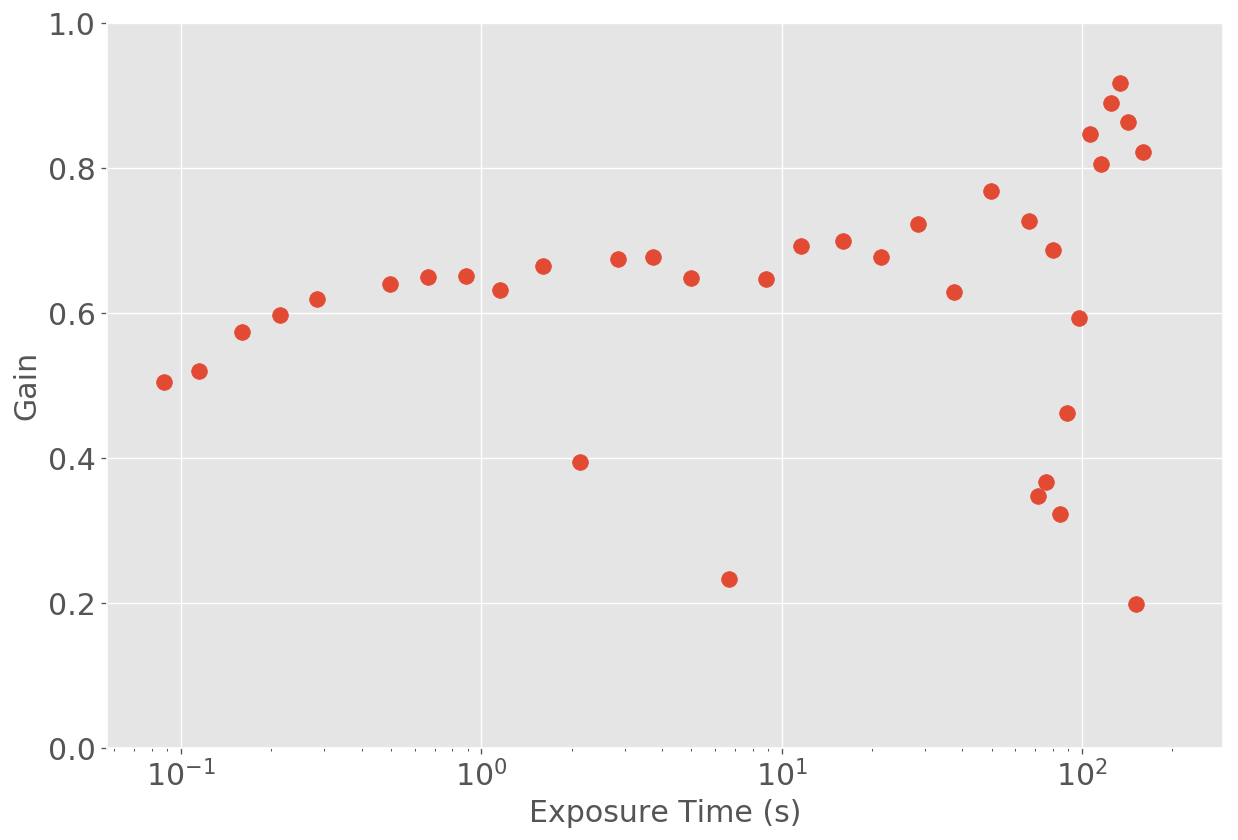

In [11]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(t, g, s=88)
#plt.yscale('log')
plt.xscale('log')
plt.ylim(0, 1)
plt.xlabel('Exposure Time (s)', size=18)
plt.ylabel('Gain', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

### Figure 2: 
We grabbed the photodiode current values from each visit by querying the metadata that comes from the FITS header for each visit. 
We then plotted the difference in this current between each visit in a pair of visits.
The values in the plot above that showed a dip in the gain are visits where the photodiode current was noticeably different
for each visit in the pair.

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/numpy/ma/core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 <a list of 7 Text yticklabel objects>)

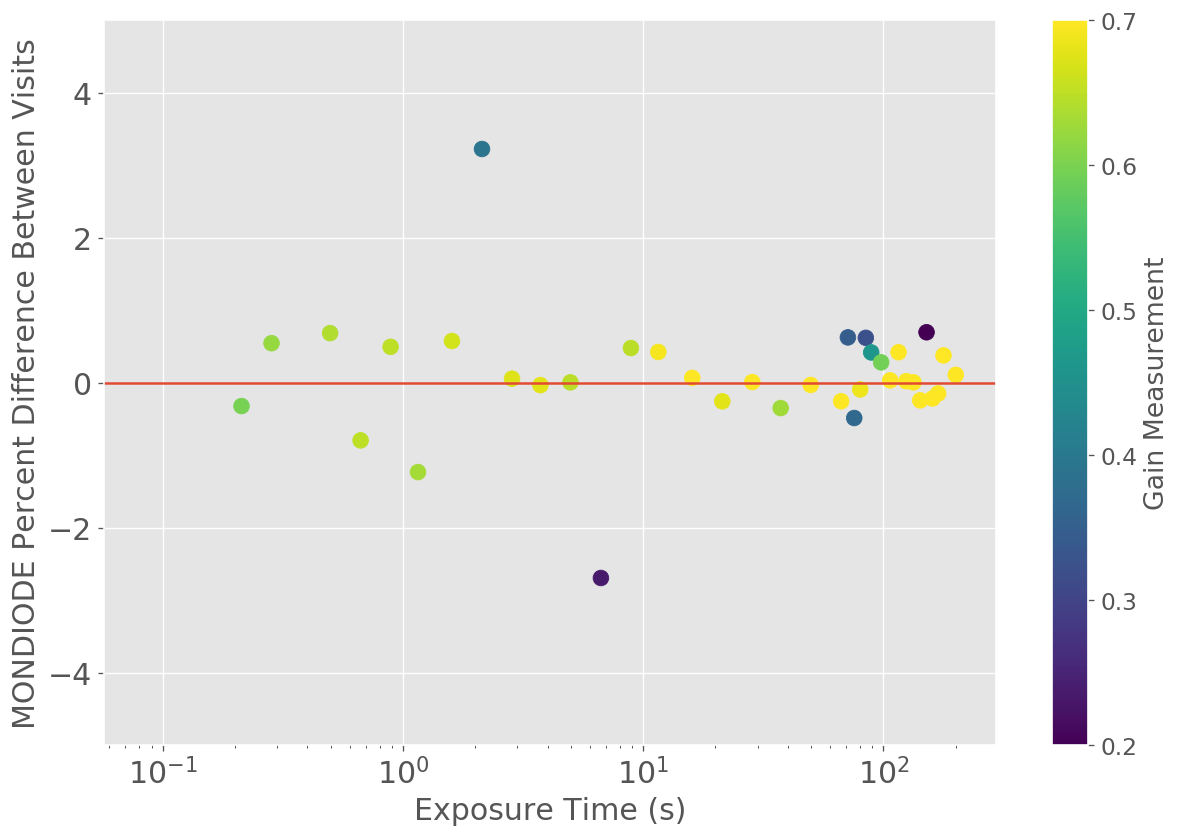

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(t, 100.*(np.abs(x) - np.abs(y))/((np.abs(x) + np.abs(y))/2), 
            c=g, vmin=0.2, vmax=0.7, s=88)
#plt.ylim(0, 1)
plt.xlabel('Exposure Time (s)', size=18)
plt.ylabel('MONDIODE Percent Difference Between Visits', size=18)
plt.xscale('log')
plt.axhline(0.0, 0.0, 1000.)
cbar = plt.colorbar()
cbar.set_label('Gain Measurement', size=16)
cbar.ax.tick_params(labelsize=14)
plt.ylim(-5, 5)
plt.xticks(size=18)
plt.yticks(size=18)

### Figure 3:

The effect from the photodiode current changes should be visible in the current level for each visit so that is plotted below.

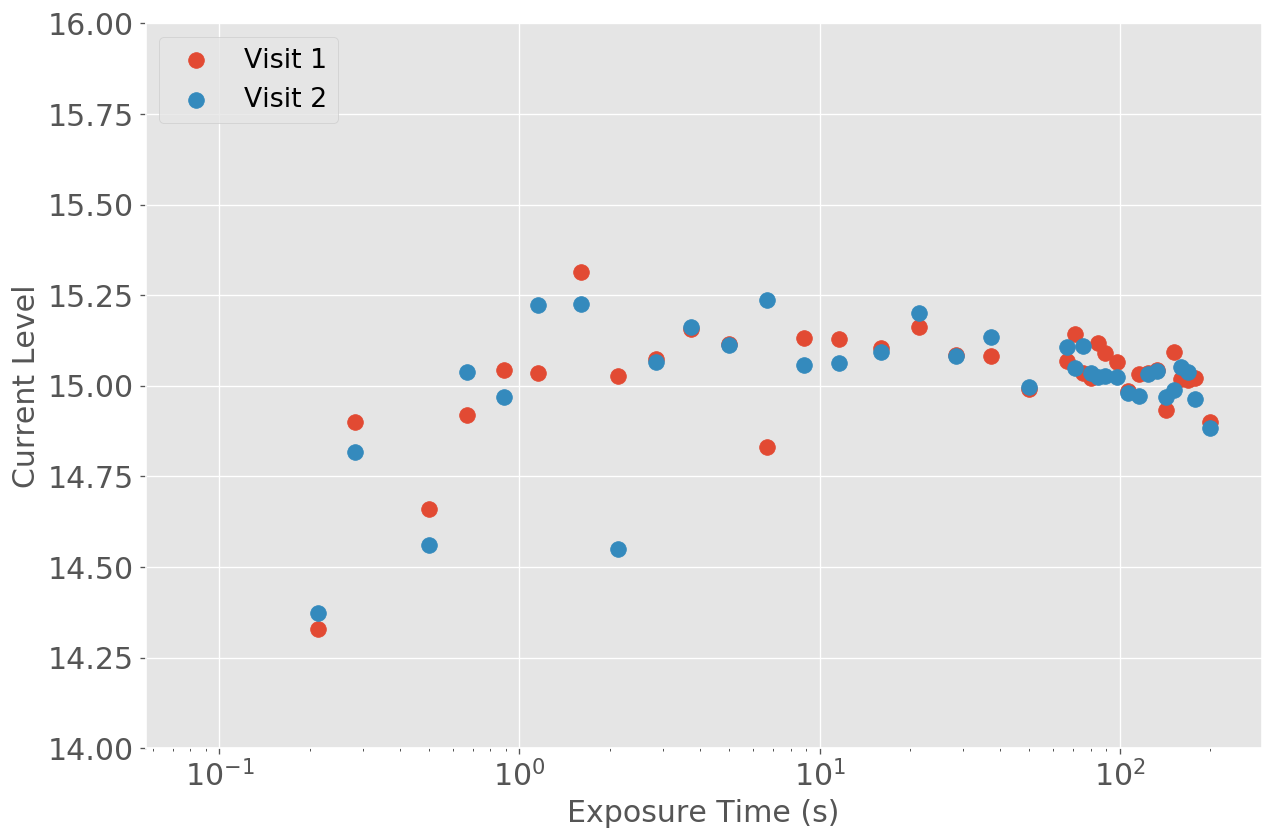

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(t, np.abs(x), s=88, label='Visit 1')
plt.scatter(t, np.abs(y), s=88, label='Visit 2')
plt.ylim(14, 16)
plt.xscale('log')
plt.xlabel('Exposure Time (s)', size=18)
plt.ylabel('Current Level', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(loc=2, fontsize=16)

### Figure 4:

The effect from the photodiode current changes should be visible in difference in the brightness between visits. That is what we see when we plot it below.

No handles with labels found to put in legend.


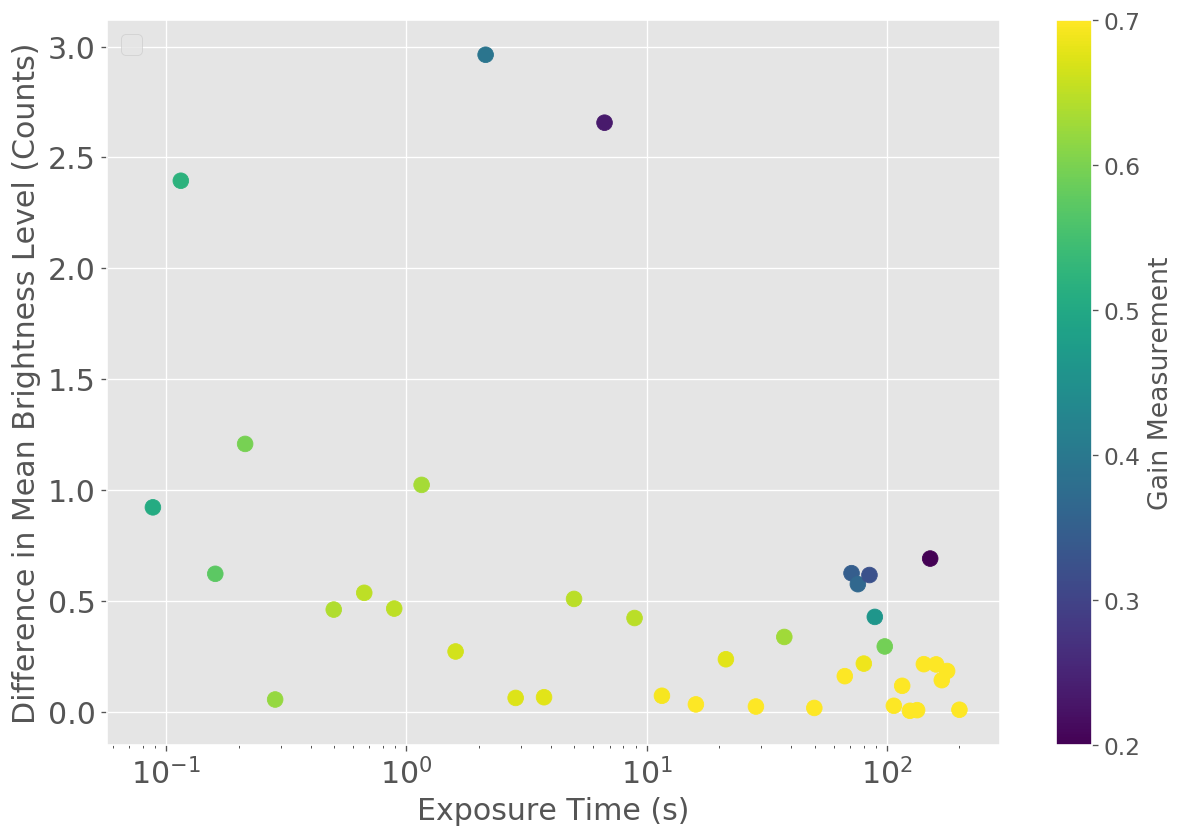

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(t, 100.*np.abs(np.array(b_1)-np.array(b_2))/np.array(b_1), s=88, c=g,
           vmin=0.2, vmax=0.7)#, label='Visit 1')
#plt.scatter(t, b_2, s=88, label='Visit 2')
plt.xscale('log')
plt.xlabel('Exposure Time (s)', size=18)
plt.ylabel('Difference in Mean Brightness Level (Counts)', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(loc=2, fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Gain Measurement', size=16)
cbar.ax.tick_params(labelsize=14)

### Figure 5:
We also plotted the mean counts/second for individual visits. The problem exposure time data appears as low value counts/second in this plot.

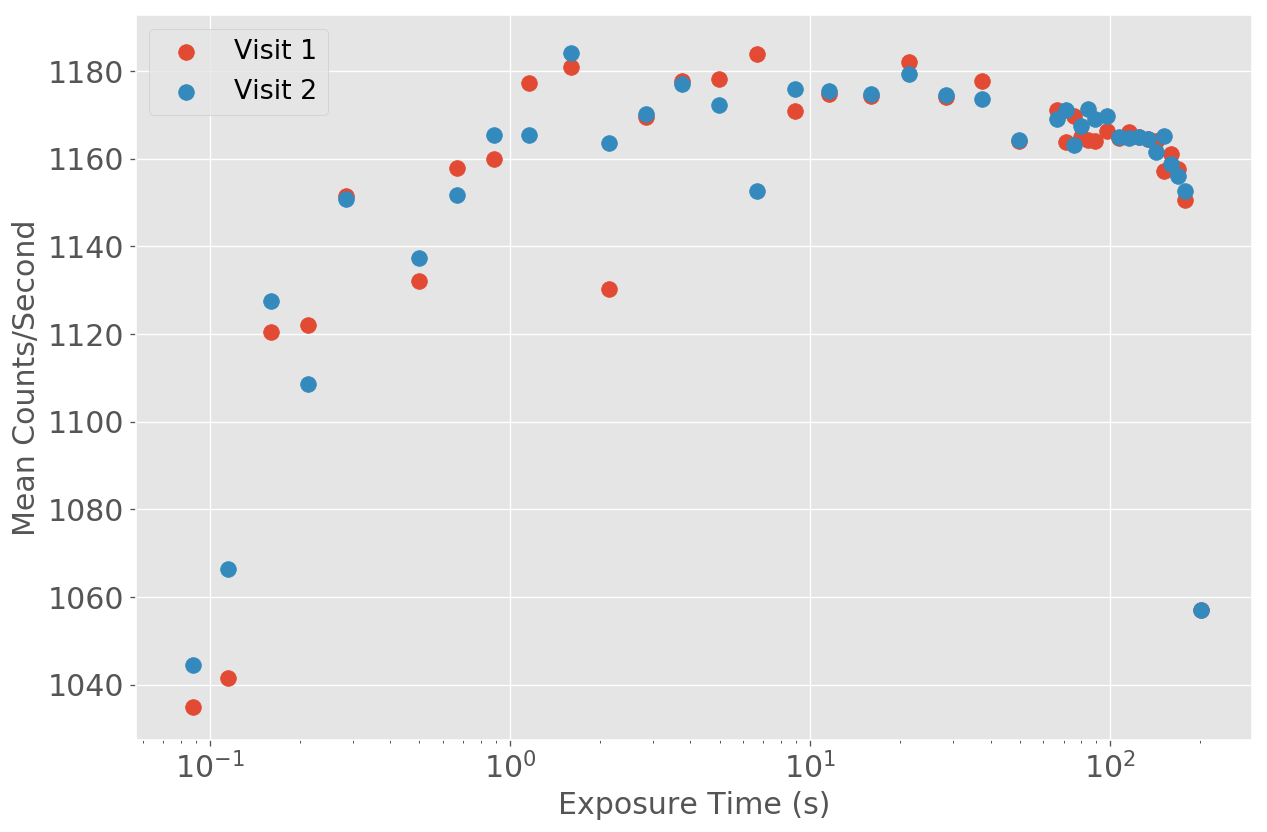

In [15]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(t, np.array(b_1)/t, s=88, label='Visit 1')# c=g,
           #vmin=0.2, vmax=0.7)#, label='Visit 1')
plt.scatter(t, np.array(b_2)/t, s=88, label='Visit 2')# c=g,
           #vmin=0.2, vmax=0.7)#, label='Visit 1')
#plt.scatter(t, b_2, s=88, label='Visit 2')
plt.xscale('log')
plt.xlabel('Exposure Time (s)', size=18)
plt.ylabel('Mean Counts/Second', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(loc=2, fontsize=16)

In [17]:
b_avg = (np.array(b_1) + np.array(b_2))/2.

In [20]:
b, a = np.polyfit(np.log10(b_avg[6:34]), np.log10(v[6:34]), 1)

In [21]:
1/b, a

(0.6086482943592885, -1.8481024536940422)

### Figure 6:

We also calculated the gain by fitting a line to the log(noise) v log(variance) of the visits. The inverse of the slope of this line fit is the gain and seems to agree with general trend value in Figure 1.

Text(2,6,'Gain = 0.609')

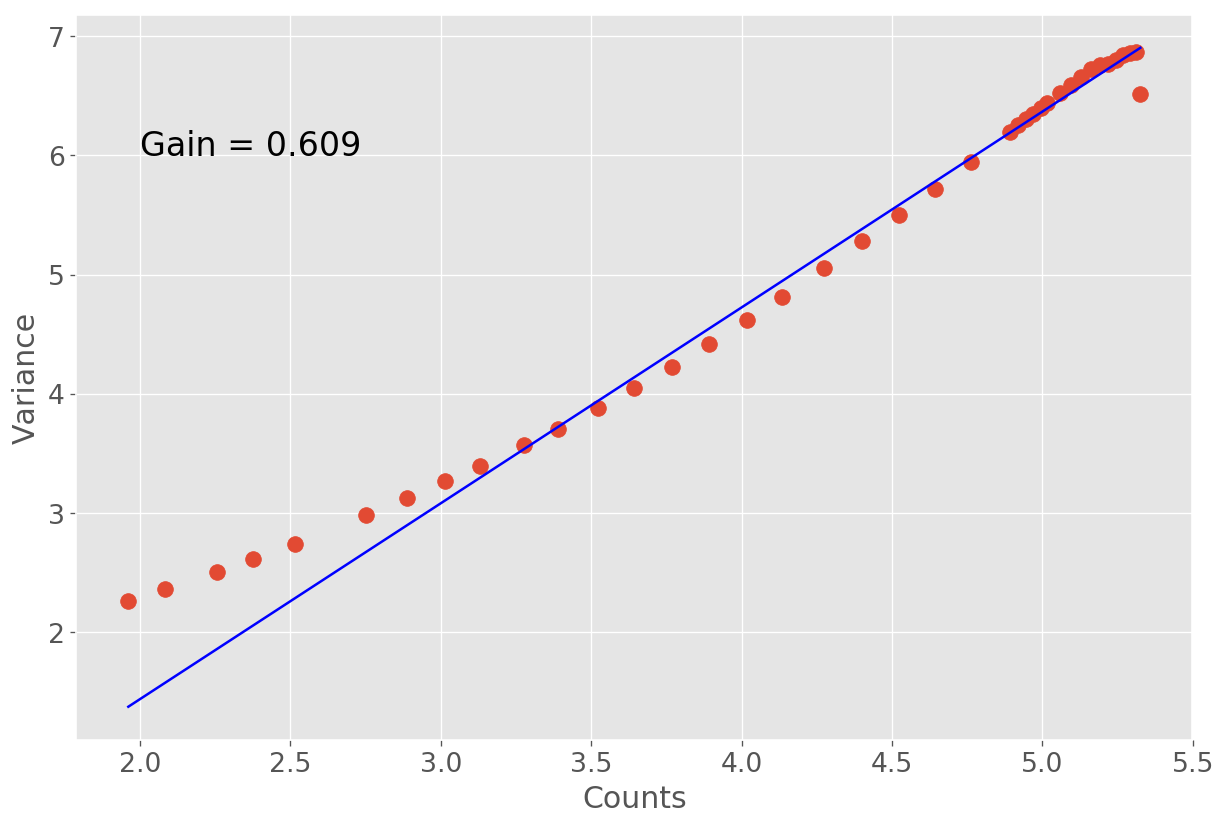

In [22]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(np.log10(b_avg), np.log10(np.array(v)), s=88)
plt.plot(np.log10(b_avg), a + b*np.log10(b_avg), c='b')
#plt.plot(b_1, )
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Counts', size=18)
plt.ylabel('Variance', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
g_val = 1./b
plt.annotate('Gain = %.3f' % g_val, xy=(2.0, 6.0), xytext=(2.0, 6.0), size=20)